# Issue Passport Details Credential

## Before running through this notebook you have configured the agent in  - [Part 1.2 - Initialising the ID Verification Agent](http://127.0.0.1:8888/notebooks/Part%201.2%20-%20Initialising%20the%20ID%20Verification%20Agent.ipynb).

## 1. Initialise a controller for Issuer

In [1]:
%autoawait
import time
import asyncio
from termcolor import colored,cprint

from aries_basic_controller.aries_controller import AriesAgentController
    
WEBHOOK_HOST = "0.0.0.0"
WEBHOOK_PORT = 8052
WEBHOOK_BASE = ""
ADMIN_URL = "http://id-verifier-agent:8051"

# Based on the aca-py agent you wish to control
agent_controller = AriesAgentController(webhook_host=WEBHOOK_HOST, webhook_port=WEBHOOK_PORT,
                                       webhook_base=WEBHOOK_BASE, admin_url=ADMIN_URL)
    

IPython autoawait is `on`, and set to use `asyncio`


## 2. Register Listeners

The handler should get called every time the controller receives a webhook with the topic issue_credential, printing out the payload. The agent calls to this webhook every time it receives an issue-credential protocol message from a credential.

In [2]:
loop = asyncio.get_event_loop()
loop.create_task(agent_controller.listen_webhooks())

def cred_handler(payload):
    print("Handle Credentials")
    exchange_id = payload['credential_exchange_id']
    state = payload['state']
    role = payload['role']
    attributes = payload['credential_proposal_dict']['credential_proposal']['attributes']
    print(f"Credential exchange {exchange_id}, role: {role}, state: {state}")
    print(f"Offering: {attributes}")
    
cred_listener = {
    "topic": "issue_credential",
    "handler": cred_handler
}

def connections_handler(payload):
    global STATE
    connection_id = payload["connection_id"]
    print("Connection message", payload, connection_id)
    STATE = payload['state']
    if STATE == 'active':
#         print('Connection {0} changed state to active'.format(connection_id))
        print(colored("Connection {0} changed state to active".format(connection_id), "red", attrs=["bold"]))


connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}

agent_controller.register_listeners([cred_listener,connection_listener], defaults=True)


## 3. Copy across the `schema_id` and `cred_def_id` stored in Part 2

In [3]:
%store -r cred_def_id
%store -r schema_id
print(cred_def_id)
print(schema_id)

MHn4W8frCddahQcL1A8N6j:3:CL:141253:default
2yWoMSfeTtYBFpUJFcnpqL:2:Passport Details:0.0.1


### 4. Make sure you have a Mobile SSI Wallet dowloaded and configured to using the Sovrin StagingNet
Please download a mobile SSI wallet such as [Connect.me](https://connect.me/), [Trinsic](https://trinsic.id/trinsic-wallet/) or any other Aries compatible wallet.

## 5. Create a connection invitation to scan with the Mobile SSI Wallet

To make a connection with an identity holders wallet we must create a connection invitation and present the QR code to be scanned by the identity holders wallet. The identity holder scan this QR code and then communicate back to the agent through the exposed ngrok endpoint.

Once a connection is in an active state, the agent and the identity holders mobile wallet now have a secure pairwise relationship over which they can exchange verifiable credentials.

## 5a. Create an Invitation

In [3]:
# Create Invitation
invite = await agent_controller.connections.create_invitation(alias="doctor")
connection_id = invite["connection_id"]
print("Connection ID", connection_id)
print("Invitation")
print(invite['invitation_url'])
inviteURL = invite['invitation_url']

Connection message {'initiator': 'self', 'invitation_mode': 'once', 'alias': 'doctor', 'updated_at': '2020-09-24 13:26:49.217938Z', 'created_at': '2020-09-24 13:26:49.217938Z', 'accept': 'auto', 'connection_id': '0b44993f-2d87-4ef1-844f-080268a4cf47', 'invitation_key': 'HyfU4LphQcnGctH5Z7KXfs3ySaoyr3bKR8F1cGYN6X1x', 'state': 'invitation', 'routing_state': 'none'} 0b44993f-2d87-4ef1-844f-080268a4cf47
Connection ID 0b44993f-2d87-4ef1-844f-080268a4cf47
Invitation
https://9b06d0b48ce8.ngrok.io?c_i=eyJAdHlwZSI6ICJkaWQ6c292OkJ6Q2JzTlloTXJqSGlxWkRUVUFTSGc7c3BlYy9jb25uZWN0aW9ucy8xLjAvaW52aXRhdGlvbiIsICJAaWQiOiAiZWMzM2RiNDktN2Q5My00OWRiLTkxZjEtOGJkNmY4NjAyNWNmIiwgInNlcnZpY2VFbmRwb2ludCI6ICJodHRwczovLzliMDZkMGI0OGNlOC5uZ3Jvay5pbyIsICJyZWNpcGllbnRLZXlzIjogWyJIeWZVNExwaFFjbkdjdEg1WjdLWGZzM3lTYW95cjNiS1I4RjFjR1lONlgxeCJdLCAibGFiZWwiOiAiSWRlbnRpdHkgVmVyaWZpY2F0aW9uIFNldmljZSJ9


## 5b. Generate QR Code to be scanned with Mobile SSI Wallet

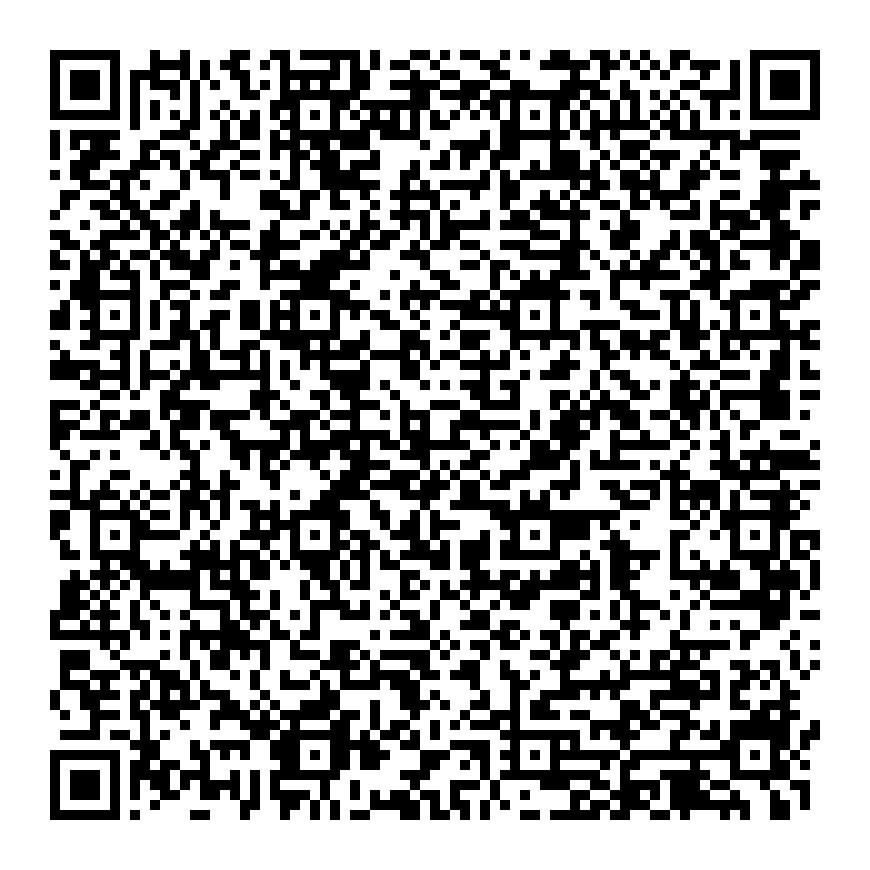

Connection message {'invitation_mode': 'once', 'state': 'request', 'their_did': 'JiNJBBeP4fVKYfSAQ7rWmp', 'accept': 'auto', 'updated_at': '2020-09-22 13:27:37.883474Z', 'routing_state': 'none', 'initiator': 'self', 'invitation_key': 'Dg2hH69ZgpCdNpdj5ZWYgvk1wGeSDDt6S6AoFEmqCgkC', 'created_at': '2020-09-22 13:27:23.635794Z', 'their_label': 'some-random-name', 'connection_id': 'f30703cf-5c96-416c-aab5-a985ddc09402'} f30703cf-5c96-416c-aab5-a985ddc09402
Connection message {'invitation_mode': 'once', 'state': 'response', 'their_did': 'JiNJBBeP4fVKYfSAQ7rWmp', 'accept': 'auto', 'updated_at': '2020-09-22 13:27:37.906647Z', 'routing_state': 'none', 'initiator': 'self', 'my_did': 'FvMqPUeFfuDdXqCrTLyCLj', 'invitation_key': 'Dg2hH69ZgpCdNpdj5ZWYgvk1wGeSDDt6S6AoFEmqCgkC', 'created_at': '2020-09-22 13:27:23.635794Z', 'their_label': 'some-random-name', 'connection_id': 'f30703cf-5c96-416c-aab5-a985ddc09402'} f30703cf-5c96-416c-aab5-a985ddc09402


In [5]:
import qrcode
# Link for connection invitation
input_data = inviteURL
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=10,
        border=5)

qr.add_data(input_data)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img.save('id-verifier-agent_invite_QRcode.png')

from IPython.display import Image
Image(width=400, filename='./id-verifier-agent_invite_QRcode.png')

## 5c. Check if established connection is in active state

In [6]:
import time

# print('Current state for ConnectionId {} is {}'.format(connection_id,STATE))
print(colored("Current state for ConnectionId {} is {}".format(connection_id,STATE), "magenta", attrs=["bold"]))
while STATE != 'active':
#     print('ConnectionId {0} is not in active state yet'.format(connection_id))
    print(colored("ConnectionId {0} is not in active state yet".format(connection_id), "yellow", attrs=["bold"]))
    trust_ping = await agent_controller.messaging.trust_ping(connection_id,'hello!')
#     print('Trust ping send to ConnectionId {0} to activate connection'.format(trust_ping))
    print(colored("Trust ping send to ConnectionId {0} to activate connection".format(trust_ping), "blue", attrs=["bold"]))
    time.sleep(5)
    
# print('ConnectionId: {0} is now active. Continue with notebook'.format(connection_id))
print(colored("ConnectionId: {0} is now active. Continue with notebook".format(connection_id), "green", attrs=["bold"]))


Current state for ConnectionId f30703cf-5c96-416c-aab5-a985ddc09402 is response
ConnectionId f30703cf-5c96-416c-aab5-a985ddc09402 is not in active state yet
Trust ping send to ConnectionId {'thread_id': '91023a5c-0d6b-46a2-8824-6d478ae2878f'} to activate connection
ConnectionId f30703cf-5c96-416c-aab5-a985ddc09402 is not in active state yet
Connection message {'invitation_mode': 'once', 'state': 'active', 'their_did': 'JiNJBBeP4fVKYfSAQ7rWmp', 'accept': 'auto', 'updated_at': '2020-09-22 13:27:50.124012Z', 'routing_state': 'none', 'initiator': 'self', 'my_did': 'FvMqPUeFfuDdXqCrTLyCLj', 'invitation_key': 'Dg2hH69ZgpCdNpdj5ZWYgvk1wGeSDDt6S6AoFEmqCgkC', 'created_at': '2020-09-22 13:27:23.635794Z', 'their_label': 'some-random-name', 'connection_id': 'f30703cf-5c96-416c-aab5-a985ddc09402'} f30703cf-5c96-416c-aab5-a985ddc09402
Connection f30703cf-5c96-416c-aab5-a985ddc09402 changed state to active
Trust ping send to ConnectionId {'thread_id': 'f101d048-f812-4390-86cc-819146ef9a7a'} to activa

## 6. Populate the Passport Details to Issue to Doctor

This would typically be done through a face to face identity check.

The notebook will ask you to input all the relevant fields.

In [7]:
passport_num = input("Please enter the doctors pasport number: ")
surname=input("Please enter the doctors surname: ")
given_names=input("Please enter the doctors given names: ")
nationality = input("Please enter the doctors nationality: ")
dob=input("Please enter the doctors date of birth: ")
sex=input("Please enter the doctors gender: ")
place_of_birth = input("Please enter the doctors place of birth: ")
date_of_issue=input("Please enter passport issuance date: ")
issuing_auth=input("Please enter the issuing authority: ")
expiry_date = input("Please enter the expiry date: ")
photograph=input("Please enter a photograph of the doctor: ")
signature=input("Please enter your signature: ")
credential_attributes = [
    {"name": "PSS Passport No", "value": passport_num},
    {"name": "PSS Surname", "value": surname},
    {"name": "PSS Given Names", "value": given_names},
    {"name": "PSS Nationality", "value": nationality},
    {"name": "PSS Date of Birth", "value": dob},
    {"name": "PSS Sex", "value": sex},
    {"name": "PSS Place of Birth", "value": place_of_birth},
    {"name": "PSS Date of Issue", "value": date_of_issue},
    {"name": "PSS IssuingAuthority", "value": issuing_auth},
    {"name": "PSS Date Of Expiry", "value": expiry_date},
    {"name": "PSS Photograph", "value": photograph},
    {"name": "PSS Signature", "value": signature}

]


print(credential_attributes)

Please enter the doctors pasport number: 123124313
Please enter the doctors surname: Coutts
Please enter the doctors given names: Octavia
Please enter the doctors nationality: UK
Please enter the doctors date of birth: 21/01/12
Please enter the doctors gender: Female
Please enter the doctors place of birth: UK
Please enter passport issuance date: 12/12/21
Please enter the issuing authority: UK
Please enter the expiry date: tomorrowq
Please enter a photograph of the doctor: photo
Please enter your signature: 123
[{'name': 'PSS Passport No', 'value': '123124313'}, {'name': 'PSS Surname', 'value': 'Coutts'}, {'name': 'PSS Given Names', 'value': 'Octavia'}, {'name': 'PSS Nationality', 'value': 'UK'}, {'name': 'PSS Date of Birth', 'value': '21/01/12'}, {'name': 'PSS Sex', 'value': 'Female'}, {'name': 'PSS Place of Birth', 'value': 'UK'}, {'name': 'PSS Date of Issue', 'value': '12/12/21'}, {'name': 'PSS IssuingAuthority', 'value': 'UK'}, {'name': 'PSS Date Of Expiry', 'value': 'tomorrowq'}, 

## 7. Send Credential

This sends a credential to the doctor's mobile wallet you just connected with.

In [8]:
record = await agent_controller.issuer.send_credential(connection_id, schema_id, cred_def_id, credential_attributes, trace=False)
record_id = record['credential_exchange_id']
state = record['state']
role = record['role']
print(f"Credential exchange {record_id}, role: {role}, state: {state}")


Credential exchange f6206d12-9803-48d4-895a-2b643ae9ec68, role: issuer, state: offer_sent
Handle Credentials
Credential exchange f6206d12-9803-48d4-895a-2b643ae9ec68, role: issuer, state: offer_sent
Offering: [{'name': 'PSS Passport No', 'value': '123124313'}, {'name': 'PSS Surname', 'value': 'Coutts'}, {'name': 'PSS Given Names', 'value': 'Octavia'}, {'name': 'PSS Nationality', 'value': 'UK'}, {'name': 'PSS Date of Birth', 'value': '21/01/12'}, {'name': 'PSS Sex', 'value': 'Female'}, {'name': 'PSS Place of Birth', 'value': 'UK'}, {'name': 'PSS Date of Issue', 'value': '12/12/21'}, {'name': 'PSS IssuingAuthority', 'value': 'UK'}, {'name': 'PSS Date Of Expiry', 'value': 'tomorrowq'}, {'name': 'PSS Photograph', 'value': 'photo'}, {'name': 'PSS Signature', 'value': '123'}]


## 8. Accept credential in Mobile SSI Wallet

## 9. End of Tutorial

Be sure to terminate the controller so you can run another tutorial.

In [10]:
response = await agent_controller.terminate()
print(response)

None


# You can now proceed to use this Passport Details credential to interact with the  [Medical School](http://127.0.0.1:8889)

Here you will present the attributes issued to you within this tutorial to a verifying entity.

You can get the token for this notebook by running `docker logs  doctors-in-training_med-school-notebook_1` or `token=$(docker logs  doctors-in-training_med-school-notebook_1  2>&1 | grep "127.0.0.1):8888/" | cut -d"=" -f2 | head -1); echo "Med School Agent - http://127.0.0.1:8889/?token=$token"`